# Media Group test task Part 2

Я постарался сделать выводы из услышанного на интервью и улучшить модель.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_cat = pd.read_excel('dataset.xlsx', sheet_name="category data")
df_gen = pd.read_excel('dataset.xlsx', sheet_name="general data")
df_cat = df_cat[df_cat['Brand'] == "DEEP RELIEF"]
weekly_sales_indexed = df_cat[['Index', 'Sales_packs']].groupby('Index').sum().reset_index()
weekly_sales = weekly_sales_indexed['Sales_packs']

В этот раз я соединю вместе оба датасета, предварительно подготовив данные.

In [3]:
df_cat.dropna(how='all', axis=1, inplace=True)
print(df_cat.columns)

Index(['Year', 'Week', 'Index', 'Product', 'Sales_packs', 'Sales_UAH',
       'Penetration', 'Pricer_per_pack', 'Brand', 'Aw_MMI',
       'Internet_insertions', 'TV_TRP', 'SOV, %', 'TRP_category'],
      dtype='object')


In [4]:
df_cat_prod_0 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 50 g"]
df_cat_prod_1 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 100 g"]
df_cat_prod_2 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 15 g"]

df_cat_prod_0.reset_index(inplace=True)
df_cat_prod_1.reset_index(inplace=True)
df_cat_prod_2.reset_index(inplace=True)

df_cat_prep = df_cat_prod_0

df_cat_prep = df_cat_prep[['Index', 'Aw_MMI', 'Internet_insertions', 'TV_TRP', 'TRP_category']]
df_cat_prep["Sales_packs"] = weekly_sales

df_pen = pd.DataFrame()
df_pen["0"] = df_cat_prod_0["Penetration"]
df_pen["1"] = df_cat_prod_1["Penetration"]
df_pen["2"] = df_cat_prod_2["Penetration"]

df_cat_prep["Penetration"] = df_pen.mean(axis=1)
df_cat_prep["Penetration"].fillna(method="ffill", inplace=True)

df_cat_prep["Pricer_per_pack"] = df_cat_prod_0["Pricer_per_pack"].div(150) +\
                                 df_cat_prod_1["Pricer_per_pack"].div(300) +\
                                 df_cat_prod_2["Pricer_per_pack"].div(45)

df_cat_prep["Aw_MMI"].interpolate(inplace=True)
df_cat_prep["Aw_MMI"].fillna(method="bfill", inplace=True)
df_cat_prep["Aw_MMI"].fillna(method="ffill", inplace=True)

In [5]:
df_gen.interpolate(inplace=True)
df_gen.fillna(method="bfill", inplace=True)
df_gen.fillna(method="ffill", inplace=True)
print(df_gen.head())

   Year  Month  Week  ...  Temperature  COVID info-noise  google_requests_for brand
0  2018      1     1  ...        -2.40               0.0                        9.5
1  2018      1     2  ...        -2.40               0.0                       11.0
2  2018      1     3  ...        -2.40               0.0                       13.5
3  2018      1     4  ...        -2.75               0.0                       14.5
4  2018      2     5  ...        -3.10               0.0                       13.5

[5 rows x 11 columns]


In [6]:
df = pd.merge(df_gen, df_cat_prep, how='inner', on='Index')
df.drop(columns=['Year', 'Month', 'Week', 'Index'], inplace=True)
print(df.columns)

Index(['IPN', 'Cons_Inflation', 'Real wage', 'UAH_to_USD', 'Temperature',
       'COVID info-noise', 'google_requests_for brand', 'Aw_MMI',
       'Internet_insertions', 'TV_TRP', 'TRP_category', 'Sales_packs',
       'Penetration', 'Pricer_per_pack'],
      dtype='object')


Теперь посмотрим на таблицу корреляций.

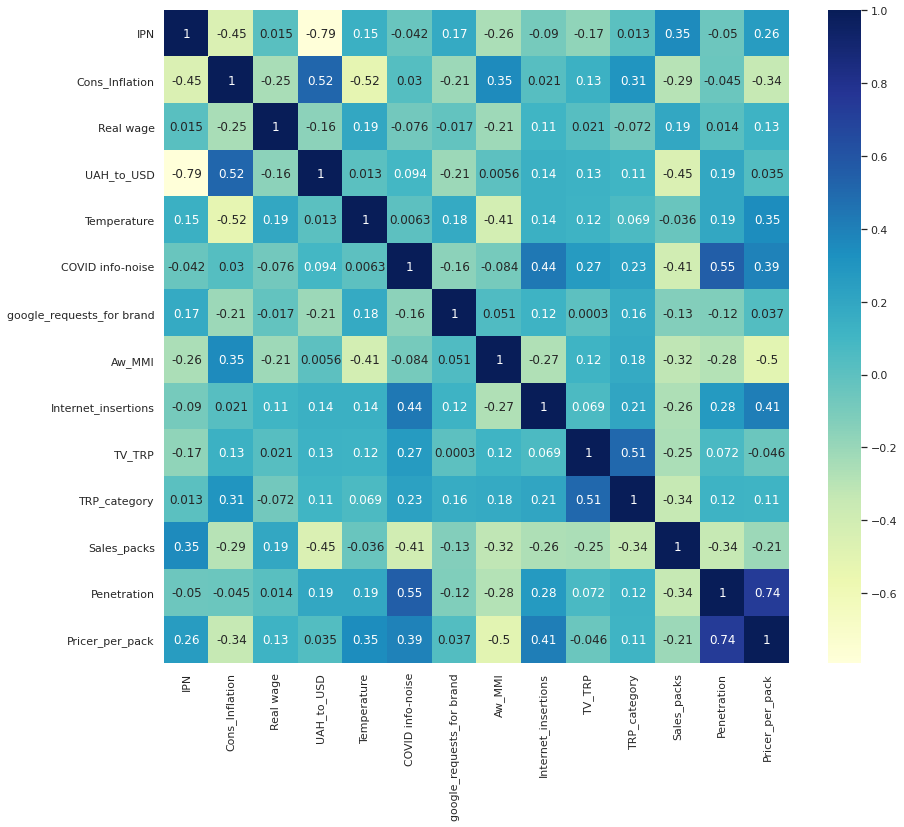

In [7]:
corr = df.corr().round(4)
sns.set(rc={'figure.figsize': (14, 12)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="YlGnBu");

Добавим сезонную и трендовую составляющие.

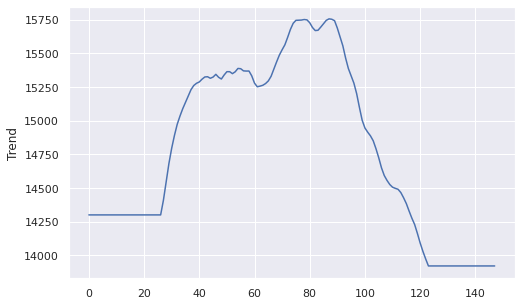

In [8]:
decomposition = sm.tsa.seasonal_decompose(weekly_sales, model='multiplicative', freq=52)

df["Trend"] = decomposition.trend
df["Trend"].fillna(method="bfill", inplace=True)
df["Trend"].fillna(method="ffill", inplace=True)
df["Seasonal"] = decomposition.seasonal

sns.set(rc={'figure.figsize': (8, 5)})
sns.lineplot(data=df["Trend"]);

Вот так выглядит та самая загадочная тренд-составляющая.


Наличие отрицательных корреляций с `Sales_packs` натолкнуло меня на мысль, что есть смысл попробовать вводить некоторые столбцы с тайм-лагом, т.к. процессы могут влиять на продажи с запозданием(например, реклама по ТВ). Размеры периодов старался подбирать в соответствии со столбиком P>|t| в `results.summary()`

In [9]:
df['Aw_MMI'] = df['Aw_MMI'].shift(periods=9)
df['Real wage'] = df['Real wage'].shift(periods=2)
df['google_requests_for brand'] = df['google_requests_for brand'].shift(periods=-3)
df.dropna(inplace=True)

Далее я разделил датасет, нормализировал данные...

In [10]:
Y = df["Sales_packs"]
X = df.drop(columns=['Sales_packs'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=7)

In [11]:
min_max_scaler = MinMaxScaler().fit(X)
X_train_scaled = min_max_scaler.transform(X_train)
X_norm = pd.DataFrame(X_train_scaled, columns=X_train.columns)

...и построил линейную регрессию.

In [12]:
model = sm.OLS(Y_train.values.reshape(-1, 1), X_norm)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              920.7
Date:                Wed, 21 Jul 2021   Prob (F-statistic):                    5.55e-89
Time:                        11:09:54   Log-Likelihood:                         -866.03
No. Observations:                 102   AIC:                                      1762.
Df Residuals:                      87   BIC:                                      1801.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Делаю предикшн по тестовому датасету.

Root of mean squared error: 991.19


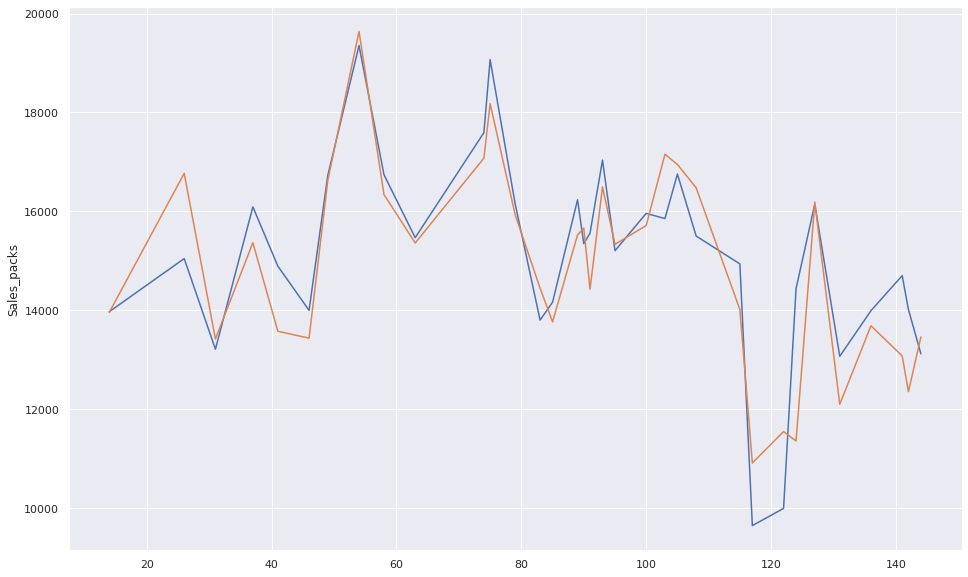

In [13]:
X_test_scaled = min_max_scaler.transform(X_test)
Y_pred = results.predict(X_test_scaled)

print('Root of mean squared error: %.2f' % mean_squared_error(Y_test, Y_pred.reshape(-1, 1), squared=False))

sns.set(rc={'figure.figsize': (16, 10)})
sns.lineplot(y=Y_pred, x=Y_test.index)
sns.lineplot(y=Y_test, x=Y_test.index);

Вывожу диаграмму с влияющими факторами.

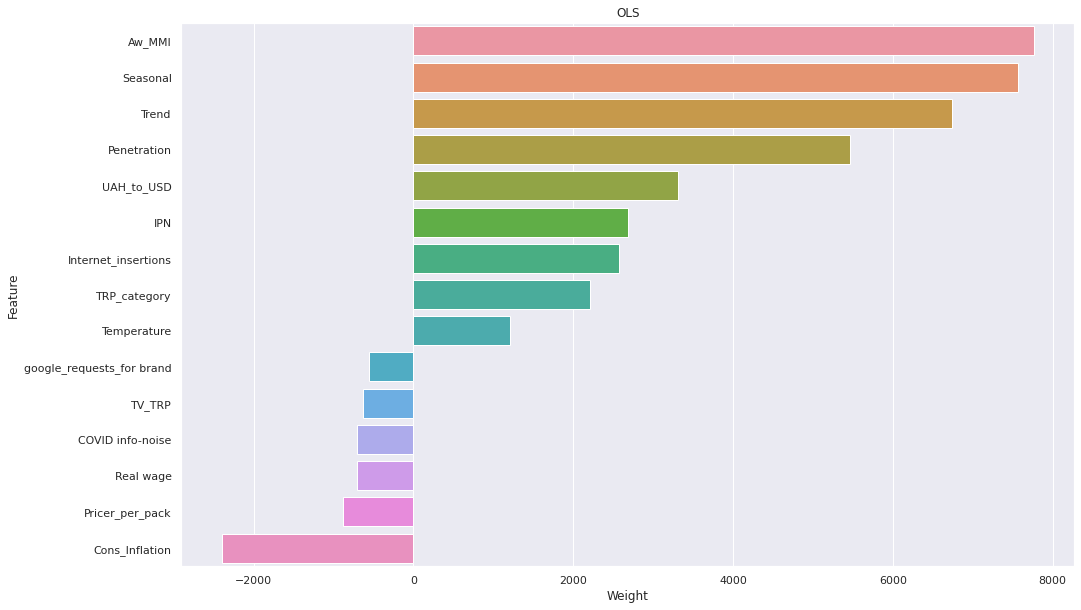

In [14]:
ols_fea = pd.DataFrame(results.params)
ols_fea["Feature"] = list(X_train)
ols_fea.sort_values(by=0, ascending=False, inplace=True)
p = sns.barplot(0, "Feature", data=ols_fea, orient='h')
p.set_xlabel("Weight")
p.set_title('OLS');